##### Read Data

In [331]:
import numpy
import requests
import json
import time

#from matplotlib.finance import candlestick2_ohlc
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import datetime as datetime

start_time = time.time() - 200*60*60
resource = requests.get("https://poloniex.com/public?command=returnChartData&currencyPair=BTC_ETH&start=%s&end=9999999999&period=1800" % start_time)
data = json.loads(resource.text)

quotes = {}
quotes['open']=numpy.asarray([item['open'] for item in data])
quotes['close']=numpy.asarray([item['close'] for item in data])
quotes['high']=numpy.asarray([item['high'] for item in data])
quotes['low']=numpy.asarray([item['low'] for item in data])


In [332]:
import pandas as pd
def sgn(x):
    return 1 if x >= 0 else -1
X = quotes['close'] - quotes['open']
y = [sgn(i) for i in X]
df = pd.DataFrame(list(zip(X, y)))
df.columns = ['close - open', 'class']
data = df['close - open'].values
N = df.shape[0]
df

,close - open,class
0,0.000000e+00,1
1,-1.905000e-05,-1
2,2.218000e-05,1
3,-3.067000e-05,-1
4,-1.763000e-05,-1
...,...,...
396,3.500000e-07,1
397,1.149000e-05,1
398,5.486000e-05,1
399,-1.009400e-04,-1


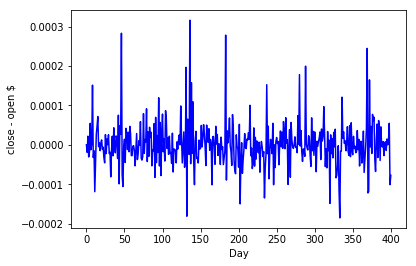

In [333]:
plt.plot(np.arange(N), data, 'b')
plt.ylabel('close - open $')
plt.xlabel('Day')
plt.show()

#### K-means для нахождения p

In [334]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

In [335]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)


In [336]:
X_train = X_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)

#### Нормируем  и находим лучшее k

In [337]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [338]:
scores = {}
for k in range(2, 13):
    classifier = KNeighborsClassifier(n_neighbors = k)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    scores[k] = accuracy_score(y_test, y_pred)


In [339]:
m = max(scores.values())
for i in scores.keys():
    if (scores[i] == m):
        p = i
        break

#### LA-2

In [340]:
def la_2(data, p, eps = 1e-6):
    E = 3 * (p + 1) # - кол-во соседей ~ 3 * (p + 1) чтобы получить более устойчивые оценки параметров
    X = data[np.arange(p) + np.arange(len(data) - p)[:, None]] # 
    omega = np.argpartition(np.sum(np.power(X - data[-p:], 2), axis=1), E)[:E] # набор номеров векторов соседей
    idx = np.arange(p)[:, None] - np.arange(p) <= 0
    Y = np.hstack((np.ones(E)[:, None], (X[omega, :, None] * X[omega, None, :])[:, idx]))#  Y*Y(a,B) = Y*X
    params = np.linalg.solve(Y.T @ Y + eps * np.eye(Y.shape[1]), Y.T @ data[omega + p])
    return params, np.sum(params * np.hstack([1, (data[-p:, None] * data[-p:])[idx]]))

#### Итеративный прогноз

In [341]:
def iterative_prediction_on_T_steps(T, X):
    predictions = np.array([])
    X_L = X
    while (T > 0):
        pred = la_2(X_L, p)[1]
        predictions = np.append(predictions, pred)
        X_L = np.append(X_L, pred)
        T -= 1
    return predictions
    

In [342]:
predictions = iterative_prediction_on_T_steps(50, data)
predictions[predictions > 0], predictions[predictions < 0] = 1, -1

In [346]:
predictions

array([ 1.,  1.,  1.,  1.,  1.,  1., -1.,  1., -1., -1., -1.,  1., -1.,
        1., -1.,  1., -1.,  1., -1., -1.,  1., -1.,  1.,  1., -1., -1.,
        1., -1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1., -1.,  1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.])